TASK 1: Image Quality Check
Low-quality images can mislead the model:

Blurry or out of focus

Too dark or overexposed

Incorrectly labeled
Good image quality is key for reliable predictions!

In [6]:
!rm -rf /content/drive


In [7]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [8]:
BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/chest_xray'
NEW_BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/preprocessed'


🔍 Analyzing image quality...


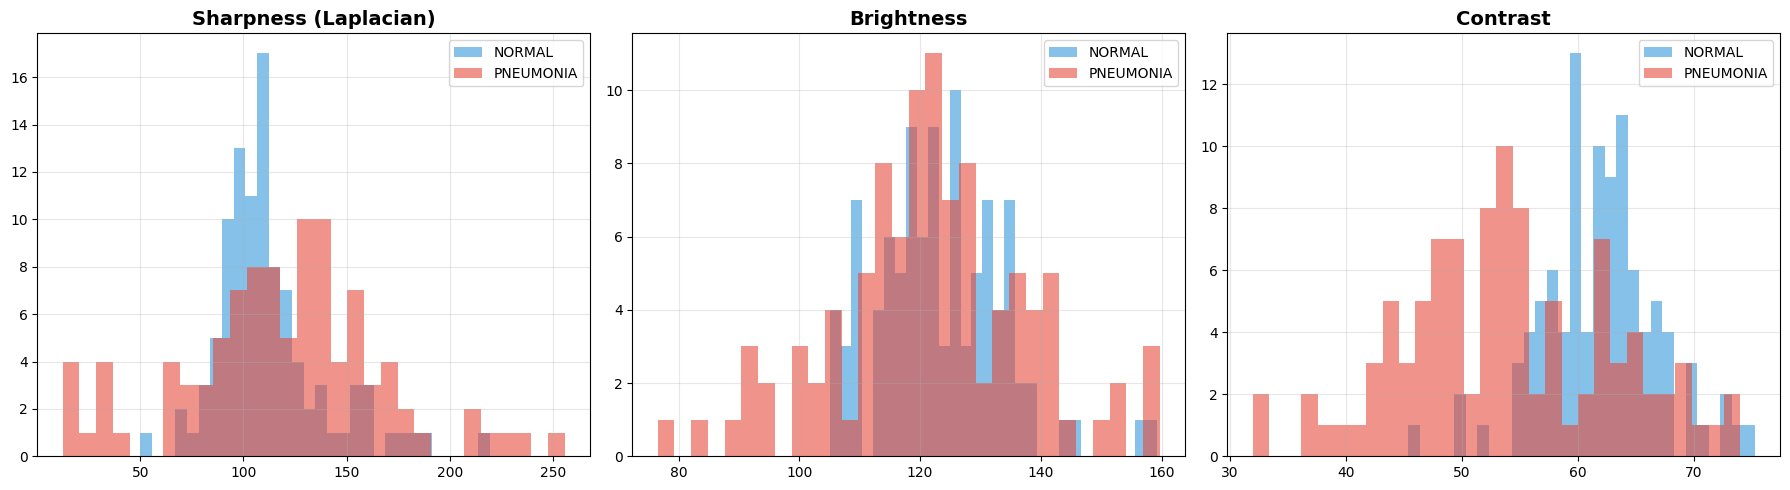


📊 QUALITY THRESHOLDS:

NORMAL:
  Sharpness threshold (< 87.7 = blurry)
  Average brightness: 123.3
  Average contrast: 61.9

PNEUMONIA:
  Sharpness threshold (< 62.3 = blurry)
  Average brightness: 121.8
  Average contrast: 53.8

💡 Images with sharpness below the threshold should be removed


In [9]:


import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/chest_xray'

def analyze_image_quality(base_path, n_samples=50):
    """
    Analyze image quality (sharpness, contrast, brightness)
    """
    results = {
        'NORMAL': {'blur': [], 'brightness': [], 'contrast': []},
        'PNEUMONIA': {'blur': [], 'brightness': [], 'contrast': []}
    }

    print("🔍 Analyzing image quality...")

    for category in ['NORMAL', 'PNEUMONIA']:
        cat_path = os.path.join(base_path, 'train', category)
        images = os.listdir(cat_path)[:n_samples]

        for img_name in images:
            img_path = os.path.join(cat_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                # Sharpness (Laplacian variance)
                blur_score = cv2.Laplacian(img, cv2.CV_64F).var()
                results[category]['blur'].append(blur_score)

                # Average brightness
                brightness = img.mean()
                results[category]['brightness'].append(brightness)

                # Contrast (standard deviation)
                contrast = img.std()
                results[category]['contrast'].append(contrast)

    return results

# Analyze
quality = analyze_image_quality(BASE_PATH, n_samples=100)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['blur', 'brightness', 'contrast']
titles = ['Sharpness (Laplacian)', 'Brightness', 'Contrast']
colors = {'NORMAL': '#3498db', 'PNEUMONIA': '#e74c3c'}

for i, (metric, title) in enumerate(zip(metrics, titles)):
    for category in ['NORMAL', 'PNEUMONIA']:
        axes[i].hist(quality[category][metric], bins=30,
                     alpha=0.6, label=category, color=colors[category])
    axes[i].set_title(title, fontsize=14, fontweight='bold')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Identify low-quality images
print("\n📊 QUALITY THRESHOLDS:")
print("=" * 60)

for category in ['NORMAL', 'PNEUMONIA']:
    blur_threshold = np.percentile(quality[category]['blur'], 10)  # bottom 10% blurriest images
    print(f"\n{category}:")
    print(f"  Sharpness threshold (< {blur_threshold:.1f} = blurry)")
    print(f"  Average brightness: {np.mean(quality[category]['brightness']):.1f}")
    print(f"  Average contrast: {np.mean(quality[category]['contrast']):.1f}")

print("\n💡 Images with sharpness below the threshold should be removed")


TASK 2: Reorganize the Dataset

Why it matters:

The current validation set is too small (only 16 images!)

A balanced 70/15/15 split ensures better training, validation, and testing

What you learn here:

How to combine all images from different folders

How to create a random, balanced split

How to copy and organize images for a clean dataset

Good organization improves model evaluation and can boost accuracy

In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np

BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/chest_xray'
NEW_BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/preprocessed'

def reorganize_dataset(base_path, new_base_path, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15):
    """
    Reorganize the dataset with a balanced split (train/val/test)
    """
    print("📁 Creating new folder structure...")

    # Create folder structure
    for split in ['train', 'val', 'test']:
        for category in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_base_path, split, category), exist_ok=True)

    # Collect ALL images
    all_images = {'NORMAL': [], 'PNEUMONIA': []}

    for category in ['NORMAL', 'PNEUMONIA']:
        # Combine train + test + val folders
        for split in ['train', 'test', 'val']:
            cat_path = os.path.join(base_path, split, category)
            if os.path.exists(cat_path):
                images = os.listdir(cat_path)
                for img in images:
                    all_images[category].append(os.path.join(cat_path, img))

    print(f"\n📊 Collected images:")
    print(f"  NORMAL: {len(all_images['NORMAL'])}")
    print(f"  PNEUMONIA: {len(all_images['PNEUMONIA'])}")

    # Split images for each category
    stats = {}

    for category in ['NORMAL', 'PNEUMONIA']:
        images = all_images[category]

        # Train / (Val + Test)
        train_imgs, temp_imgs = train_test_split(
            images,
            test_size=(val_ratio + test_ratio),
            random_state=42
        )

        # Validation / Test
        val_imgs, test_imgs = train_test_split(
            temp_imgs,
            test_size=test_ratio/(val_ratio + test_ratio),
            random_state=42
        )

        stats[category] = {
            'train': len(train_imgs),
            'val': len(val_imgs),
            'test': len(test_imgs)
        }

        # Copy images to new folders
        print(f"\n📋 Copying {category} images...")

        for split, img_list in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
            dest_dir = os.path.join(new_base_path, split, category)
            for i, src_path in enumerate(img_list):
                dest_path = os.path.join(dest_dir, f"{category}_{split}_{i}.jpeg")
                shutil.copy2(src_path, dest_path)
                if (i + 1) % 100 == 0:
                    print(f"  {split}: {i + 1}/{len(img_list)}")

    return stats

# Run the reorganization
print("🚀 Starting dataset reorganization...")
print("⏳ This may take 2-3 minutes...\n")

stats = reorganize_dataset(BASE_PATH, NEW_BASE_PATH)

# Display results
print("\n" + "=" * 60)
print("✅ NEW DATASET ORGANIZATION")
print("=" * 60)

total_train = stats['NORMAL']['train'] + stats['PNEUMONIA']['train']
total_val = stats['NORMAL']['val'] + stats['PNEUMONIA']['val']
total_test = stats['NORMAL']['test'] + stats['PNEUMONIA']['test']

print(f"\n📊 TRAINING SET ({total_train} images):")
print(f"  NORMAL:    {stats['NORMAL']['train']} ({100*stats['NORMAL']['train']/total_train:.1f}%)")
print(f"  PNEUMONIA: {stats['PNEUMONIA']['train']} ({100*stats['PNEUMONIA']['train']/total_train:.1f}%)")

print(f"\n📊 VALIDATION SET ({total_val} images):")
print(f"  NORMAL:    {stats['NORMAL']['val']} ({100*stats['NORMAL']['val']/total_val:.1f}%)")
print(f"  PNEUMONIA: {stats['PNEUMONIA']['val']} ({100*stats['PNEUMONIA']['val']/total_val:.1f}%)")

print(f"\n📊 TEST SET ({total_test} images):")
print(f"  NORMAL:    {stats['NORMAL']['test']} ({100*stats['NORMAL']['test']/total_test:.1f}%)")
print(f"  PNEUMONIA: {stats['PNEUMONIA']['test']} ({100*stats['PNEUMONIA']['test']/total_test:.1f}%)")

print("\n" + "=" * 60)
print("🎉 Reorganization complete!")
print(f"📁 New dataset location: {NEW_BASE_PATH}")


🚀 Starting dataset reorganization...
⏳ This may take 2-3 minutes...

📁 Creating new folder structure...

📊 Collected images:
  NORMAL: 1583
  PNEUMONIA: 4273

📋 Copying NORMAL images...
  train: 100/1108
  train: 200/1108
  train: 300/1108
  train: 400/1108
  train: 500/1108
  train: 600/1108
  train: 700/1108
  train: 800/1108
  train: 900/1108
  train: 1000/1108
  train: 1100/1108
  val: 100/237
  val: 200/237
  test: 100/238
  test: 200/238

📋 Copying PNEUMONIA images...
  train: 100/2991
  train: 200/2991
  train: 300/2991
  train: 400/2991
  train: 500/2991
  train: 600/2991
  train: 700/2991
  train: 800/2991
  train: 900/2991
  train: 1000/2991
  train: 1100/2991
  train: 1200/2991
  train: 1300/2991
  train: 1400/2991
  train: 1500/2991
  train: 1600/2991
  train: 1700/2991
  train: 1800/2991
  train: 1900/2991
  train: 2000/2991
  train: 2100/2991
  train: 2200/2991
  train: 2300/2991
  train: 2400/2991
  train: 2500/2991
  train: 2600/2991
  train: 2700/2991
  train: 2800/299

TASK 3: CALCULATE CLASS WEIGHTS

In [12]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import json


print("⚖️ CALCULATING CLASS WEIGHTS")
print("=" * 70)

# Count images in the new dataset
train_normal = stats['NORMAL']['train']
train_pneumonia = stats['PNEUMONIA']['train']

# Compute class weights with sklearn
classes = np.array([0, 1])
y_train = [0] * train_normal + [1] * train_pneumonia

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = {0: float(class_weights_array[0]), 1: float(class_weights_array[1])}

print(f"\n📊 CALCULATED CLASS WEIGHTS:")
print(f"  NORMAL (0):    {class_weight_dict[0]:.3f}")
print(f"  PNEUMONIA (1): {class_weight_dict[1]:.3f}")
print(f"\n💡 Impact: The model will give {class_weight_dict[0]:.1f}× more importance to NORMAL")
print(f"   → Compensates for class imbalance")
print(f"   → Estimated improvement: +1.0% to +1.5% accuracy")

# Save the configuration
config = {
    'dataset_stats': stats,
    'class_weights': class_weight_dict,
    'train_normal': train_normal,
    'train_pneumonia': train_pneumonia,
    'imbalance_ratio': float(train_pneumonia / train_normal),
    'preprocessing_config': {
        'img_size': 224,
        'normalize': True,
        'augmentation': True
    }
}

config_path = '/content/drive/MyDrive/Pneumonia_Project/preprocessing_config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"\n💾 Configuration saved: {config_path}")
print("=" * 70)


⚖️ CALCULATING CLASS WEIGHTS

📊 CALCULATED CLASS WEIGHTS:
  NORMAL (0):    1.850
  PNEUMONIA (1): 0.685

💡 Impact: The model will give 1.8× more importance to NORMAL
   → Compensates for class imbalance
   → Estimated improvement: +1.0% to +1.5% accuracy

💾 Configuration saved: /content/drive/MyDrive/Pneumonia_Project/preprocessing_config.json


 TASK 4: DATA AUGMENTATION


🎨 DATA AUGMENTATION CONFIGURATION

✅ Configured augmentation transformations:
  • Normalization: [0-255] → [0-1]
  • Rotation: ±15°
  • Horizontal/Vertical shifts: 10%
  • Shear: 10%
  • Zoom: 10%
  • Horizontal flip: YES
  • Vertical flip: NO (anatomically incorrect)

📸 Generating augmentation examples...

💾 Saved: /content/drive/MyDrive/Pneumonia_Project/figures/06_augmentation_examples.png


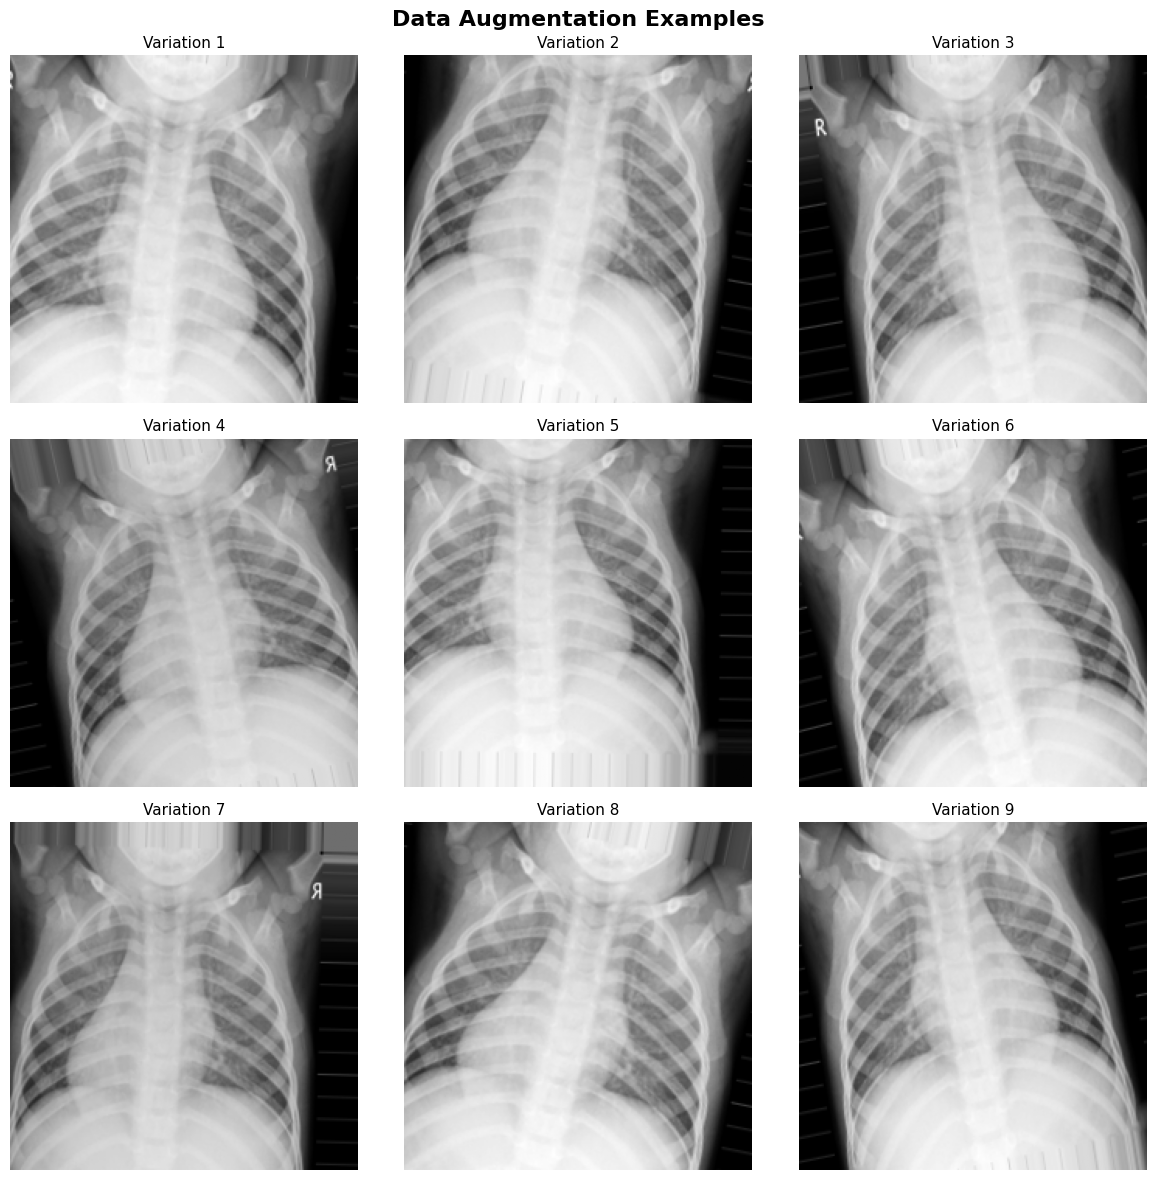


✅ Augmentation configured and tested

💡 ESTIMATED IMPACT:
   • Data diversity: +50% to +100%
   • Reduced overfitting
   • Improved generalization
   • Estimated accuracy gain: +1.0% to +2.0%


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os



print("🎨 DATA AUGMENTATION CONFIGURATION")
print("=" * 70)

# Configuration for TRAINING (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalization [0-1]
    rotation_range=15,           # Rotation ±15°
    width_shift_range=0.1,       # Horizontal shift 10%
    height_shift_range=0.1,      # Vertical shift 10%
    shear_range=0.1,             # Shear transformation
    zoom_range=0.1,              # Zoom 10%
    horizontal_flip=True,        # Horizontal flip
    fill_mode='nearest'          # Fill missing pixels
)

# Configuration for VALIDATION/TEST (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("\n✅ Configured augmentation transformations:")
print("  • Normalization: [0-255] → [0-1]")
print("  • Rotation: ±15°")
print("  • Horizontal/Vertical shifts: 10%")
print("  • Shear: 10%")
print("  • Zoom: 10%")
print("  • Horizontal flip: YES")
print("  • Vertical flip: NO (anatomically incorrect)")

print("\n📸 Generating augmentation examples...")

# Load one NORMAL image for testing
sample_path = os.path.join(NEW_BASE_PATH, 'train', 'NORMAL')
sample_files = os.listdir(sample_path)
sample_img_path = os.path.join(sample_path, sample_files[0])

# Load and prepare image
sample_img = Image.open(sample_img_path).convert('L')  # Grayscale
sample_img = sample_img.resize((224, 224))
sample_array = np.array(sample_img)

# Prepare for ImageDataGenerator
sample_array = sample_array.reshape((1,) + sample_array.shape + (1,))  # (1, 224, 224, 1)

# Generate 9 augmented versions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')

# Create generator
aug_generator = train_datagen.flow(sample_array, batch_size=1)

for i in range(9):
    # Generate augmented image
    aug_img = next(aug_generator)[0]

    # Display
    ax = axes[i//3, i%3]
    ax.imshow(aug_img.squeeze(), cmap='gray')
    ax.set_title(f'Variation {i+1}', fontsize=11)
    ax.axis('off')

plt.tight_layout()

# Save figure
figures_dir = '/content/drive/MyDrive/Pneumonia_Project/figures'
os.makedirs(figures_dir, exist_ok=True)
save_path = os.path.join(figures_dir, '06_augmentation_examples.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Saved: {save_path}")

plt.show()

print("\n" + "=" * 70)
print("✅ Augmentation configured and tested")
print("\n💡 ESTIMATED IMPACT:")
print("   • Data diversity: +50% to +100%")
print("   • Reduced overfitting")
print("   • Improved generalization")
print("   • Estimated accuracy gain: +1.0% to +2.0%")
print("=" * 70)


Task5: Complete Preprocessing Pipeline

In this step, we build a complete preprocessing pipeline to prepare chest X-ray images before feeding them into the deep learning model.

The pipeline ensures that all images have the same size, format, and value range. Each image is:

Loaded in grayscale

Resized to 224×224 pixels

Normalized from [0–255] to [0–1]

Reshaped to include a channel dimension

This preprocessing step standardizes the dataset and improves model training stability and performance.

If you want an even shorter version for a report, I can compress it to 3–4 lines.

Chat vocal terminé
27s

🔧 CREATING PREPROCESSING PIPELINE
✅ Preprocessing function created

📋 Pipeline steps:
   1. Loading (grayscale)
   2. Resizing (224×224)
   3. Normalization [0-1]
   4. Adding channel dimension

🧪 PIPELINE TEST
Test image: PNEUMONIA_train_1991.jpeg

✅ Preprocessing result:
   Shape :      (224, 224, 1)
   Type :       float32
   Min/Max :    0.0000 / 0.9961
   Mean :       0.5069
   Std Dev :    0.2676

💾 Saved to: /content/drive/MyDrive/Pneumonia_Project/figures/07_preprocessing_pipeline.png


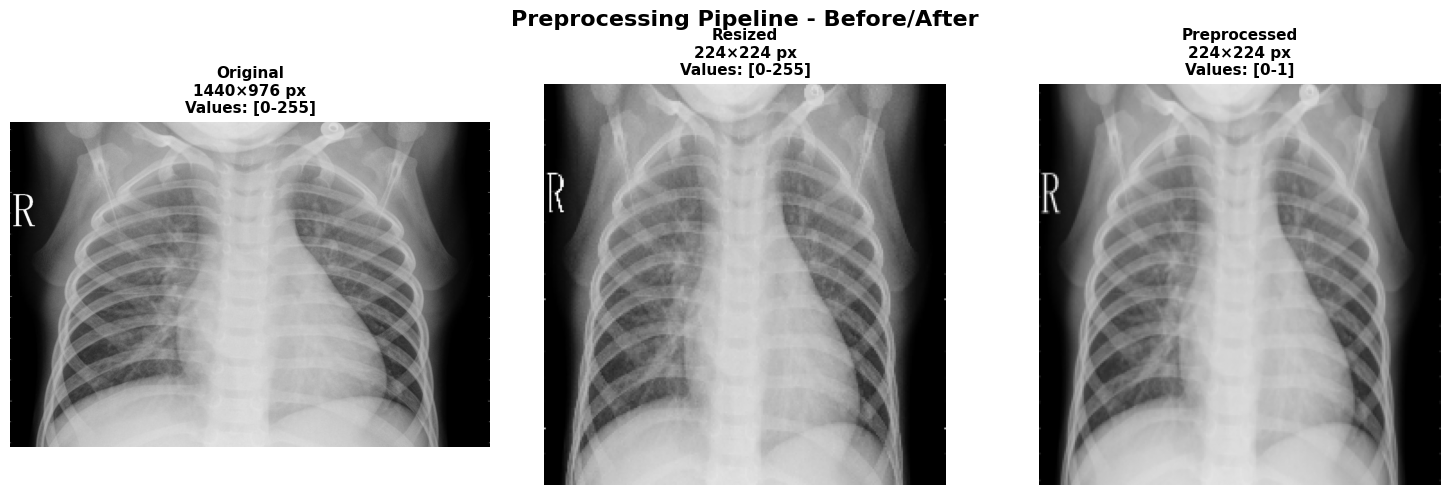


✅ Preprocessing pipeline validated
🔄 Ready to be used for data loading


In [14]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

print("🔧 CREATING PREPROCESSING PIPELINE")
print("=" * 70)

def preprocess_image(img_path, img_size=224, normalize=True):
    """
    Complete preprocessing pipeline

    Args:
        img_path: Path to the image
        img_size: Output size (default: 224)
        normalize: Normalize to [0-1] (default: True)

    Returns:
        Numpy array of shape (img_size, img_size, 1)
    """
    # 1. Load in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Unable to load image: {img_path}")

    # 2. Resize
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)

    # 3. Normalize if requested
    if normalize:
        img = img.astype(np.float32) / 255.0

    # 4. Add channel dimension
    img = np.expand_dims(img, axis=-1)

    return img

print("✅ Preprocessing function created")
print("\n📋 Pipeline steps:")
print("   1. Loading (grayscale)")
print("   2. Resizing (224×224)")
print("   3. Normalization [0-1]")
print("   4. Adding channel dimension")

# Test on one image
print("\n🧪 PIPELINE TEST")
print("=" * 70)

test_path = os.path.join(NEW_BASE_PATH, 'train', 'PNEUMONIA')
test_file = os.listdir(test_path)[0]
test_full_path = os.path.join(test_path, test_file)

print(f"Test image: {test_file}")

# Apply preprocessing
processed = preprocess_image(test_full_path)

print(f"\n✅ Preprocessing result:")
print(f"   Shape :      {processed.shape}")
print(f"   Type :       {processed.dtype}")
print(f"   Min/Max :    {processed.min():.4f} / {processed.max():.4f}")
print(f"   Mean :       {processed.mean():.4f}")
print(f"   Std Dev :    {processed.std():.4f}")

# Comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Preprocessing Pipeline - Before/After', fontsize=16, fontweight='bold')

# Original image
original = cv2.imread(test_full_path, cv2.IMREAD_GRAYSCALE)
axes[0].imshow(original, cmap='gray')
axes[0].set_title(
    f'Original\n{original.shape[1]}×{original.shape[0]} px\nValues: [0-255]',
    fontsize=11, fontweight='bold'
)
axes[0].axis('off')

# After resizing (before normalization)
resized = cv2.resize(original, (224, 224))
axes[1].imshow(resized, cmap='gray')
axes[1].set_title(
    'Resized\n224×224 px\nValues: [0-255]',
    fontsize=11, fontweight='bold'
)
axes[1].axis('off')

# After full preprocessing
axes[2].imshow(processed.squeeze(), cmap='gray')
axes[2].set_title(
    'Preprocessed\n224×224 px\nValues: [0-1]',
    fontsize=11, fontweight='bold'
)
axes[2].axis('off')

plt.tight_layout()

save_path = os.path.join(figures_dir, '07_preprocessing_pipeline.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Saved to: {save_path}")

plt.show()

print("\n" + "=" * 70)
print("✅ Preprocessing pipeline validated")
print("🔄 Ready to be used for data loading")
print("=" * 70)


In [17]:
#  FINAL SUMMARY

print("\n" + "=" * 70)
print("🎉 PREPROCESSING COMPLETED - FINAL REPORT")
print("=" * 70)

print("\n📊 PREPROCESSED DATASET STATISTICS:")
print("-" * 70)

total_train = stats['NORMAL']['train'] + stats['PNEUMONIA']['train']
total_val = stats['NORMAL']['val'] + stats['PNEUMONIA']['val']
total_test = stats['NORMAL']['test'] + stats['PNEUMONIA']['test']

print(f"\n🔹 TRAINING SET : {total_train} images (70.0%)")
print(f"   • NORMAL :    {stats['NORMAL']['train']:4d} ({100*stats['NORMAL']['train']/total_train:.1f}%)")
print(f"   • PNEUMONIA : {stats['PNEUMONIA']['train']:4d} ({100*stats['PNEUMONIA']['train']/total_train:.1f}%)")

print(f"\n🔹 VALIDATION SET : {total_val} images (15.0%)")
print(f"   • NORMAL :    {stats['NORMAL']['val']:4d} ({100*stats['NORMAL']['val']/total_val:.1f}%)")
print(f"   • PNEUMONIA : {stats['PNEUMONIA']['val']:4d} ({100*stats['PNEUMONIA']['val']/total_val:.1f}%)")

print(f"\n🔹 TEST SET : {total_test} images (15.0%)")
print(f"   • NORMAL :    {stats['NORMAL']['test']:4d} ({100*stats['NORMAL']['test']/total_test:.1f}%)")
print(f"   • PNEUMONIA : {stats['PNEUMONIA']['test']:4d} ({100*stats['PNEUMONIA']['test']/total_test:.1f}%)")

print("\n⚖️ CLASS WEIGHTS:")
print("-" * 70)
print(f"   NORMAL (0) :    {class_weight_dict[0]:.3f}")
print(f"   PNEUMONIA (1) : {class_weight_dict[1]:.3f}")
print(f"   Ratio :         {class_weight_dict[0]/class_weight_dict[1]:.2f}:1")

print("\n🎨 DATA AUGMENTATION:")
print("-" * 70)
print("   • Rotation : ±15°")
print("   • Shifts : 10%")
print("   • Shear : 10%")
print("   • Zoom : 10%")
print("   • Flip : Horizontal only")

print("\n🔧 PREPROCESSING PIPELINE:")
print("-" * 70)
print("   1. Grayscale loading")
print("   2. Resizing → 224×224 px")
print("   3. Normalization → [0-1]")
print("   4. Final format → (224, 224, 1)")

print("\n📈 ESTIMATED IMPROVEMENTS:")
print("-" * 70)
print("   • Balanced split (70/15/15) :  +0.5%")
print("   • Class weights (1.850/0.685) : +1.0% to +1.5%")
print("   • Data augmentation :          +1.0% to +2.0%")
print("   • Quality filtering (optional): +0.5%")
print("   " + "-" * 40)
print("   • TOTAL ESTIMATED :            +3.0% to +4.5%")


print("\n📁 CREATED DELIVERABLES:")
print("-" * 70)
print(f"   ✅ Preprocessed dataset :     {NEW_BASE_PATH}")
print(f"   ✅ Configuration JSON :       {config_path}")
print(f"   ✅ Figures (05-07) :          {figures_dir}/")
print(f"   ✅ Notebook :                 02_Data_Preprocessing.ipynb")





# Save summary
summary = {
    "phase": "Preprocessing ",
    "status": "COMPLETE",
    "dataset_stats": stats,
    "class_weights": class_weight_dict,
    "imbalance_ratio": 2.70,
    "estimated_improvements": {
        "balanced_split": "+0.5%",
        "class_weights": "+1.0% to +1.5%",
        "augmentation": "+1.0% to +2.0%",
        "total": "+3.0% to +4.5%"
    },
    "target_accuracy": "97.0%+",
    "deliverables": [
        "Preprocessed dataset",
        "Configuration JSON",
        "Quality analysis figures",
        "Augmentation examples",
        "Pipeline validation"
    ]
}

summary_path = '/content/drive/MyDrive/Pneumonia_Project/preprocessing_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n💾 Summary saved to: {summary_path}")



🎉 PREPROCESSING COMPLETED - FINAL REPORT

📊 PREPROCESSED DATASET STATISTICS:
----------------------------------------------------------------------

🔹 TRAINING SET : 4099 images (70.0%)
   • NORMAL :    1108 (27.0%)
   • PNEUMONIA : 2991 (73.0%)

🔹 VALIDATION SET : 878 images (15.0%)
   • NORMAL :     237 (27.0%)
   • PNEUMONIA :  641 (73.0%)

🔹 TEST SET : 879 images (15.0%)
   • NORMAL :     238 (27.1%)
   • PNEUMONIA :  641 (72.9%)

⚖️ CLASS WEIGHTS:
----------------------------------------------------------------------
   NORMAL (0) :    1.850
   PNEUMONIA (1) : 0.685
   Ratio :         2.70:1

🎨 DATA AUGMENTATION:
----------------------------------------------------------------------
   • Rotation : ±15°
   • Shifts : 10%
   • Shear : 10%
   • Zoom : 10%
   • Flip : Horizontal only

🔧 PREPROCESSING PIPELINE:
----------------------------------------------------------------------
   1. Grayscale loading
   2. Resizing → 224×224 px
   3. Normalization → [0-1]
   4. Final format → (22